In [1]:
import numpy as np
# import cupy as cp
import torch
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import trimesh

In [2]:
film = np.zeros((100, 100, 100))

bottom = 70
film[:, :, 0:bottom] = 10 # bottom


for i in range(20):
    film[:, 20+i, 10:10+3*i] = 0

for j in range(20):
    film[:, 80-j, 10:10+3*j] = 0

film[:, 40:61, 10:70] = 0

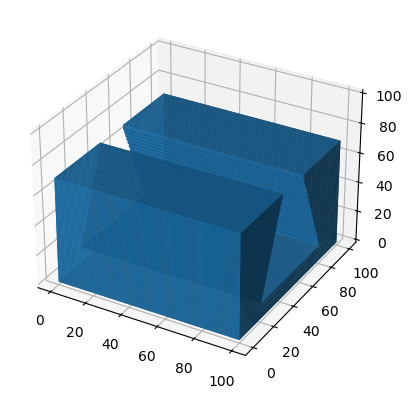

In [13]:
film = np.zeros((100, 100, 100))

bottom = 70
film[:, :, 0:bottom] = 10 # bottom


for i in range(20):
    film[:, 20+i, 10:10+3*i] = 0

for j in range(20):
    film[:, 80-j, 10:10+3*j] = 0

film[:, 40:61, 10:70] = 0
# film[:, 61, 10:70] = 0
indice_wall = np.array(film == 10)
# in_depo = np.logical_and(result > 0, result < 1)
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
# ax.voxels(surface_depo, edgecolor='k')
ax.voxels(indice_wall)
# ax.voxels(in_depo)

plt.show()

In [3]:
surface_sparse = torch.zeros((100, 100, 100))

def scanZ(film):
    xshape = film.shape[0]
    yshape = film.shape[1]
    zshape = film.shape[2]
    print(zshape)
    for i in range(zshape-1):
        for j in range(xshape-1):
            for k in range(yshape-1):
                if (film[j, k, i] == 0 and film[j, k, i-1] != 0) or (film[j, k, i] == 0 and film[j, k, i+1] != 0) \
                or (film[j, k, i] == 0 and film[j-1, k, i] != 0) or (film[j, k, i] == 0 and film[j+1, k, i] != 0) \
                or (film[j, k, i] == 0 and film[j, k-1, i] != 0) or (film[j, k, i] == 0 and film[j, k+1, i] != 0):
                    surface_sparse[j,k,i] = 1
    return surface_sparse.to_sparse()

In [4]:
test = scanZ(film)
print(test)

100
tensor(indices=tensor([[ 0,  0,  0,  ..., 98, 98, 98],
                       [ 0,  1,  2,  ..., 96, 97, 98],
                       [70, 70, 70,  ..., 70, 70, 70]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(100, 100, 100), nnz=25245, layout=torch.sparse_coo)


In [5]:
test.indices().shape

torch.Size([3, 25245])

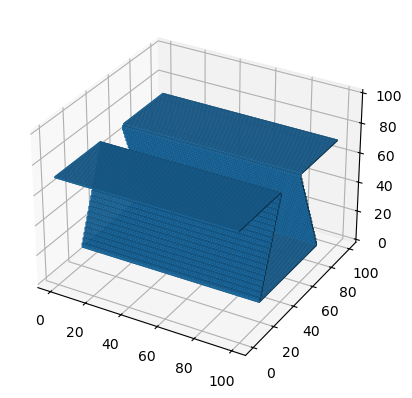

In [6]:
testplt = test.to_dense()
# print(testplt)
indice_wall = np.array(testplt == 1)
# in_depo = np.logical_and(result > 0, result < 1)
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
# ax.voxels(surface_depo, edgecolor='k')
ax.voxels(indice_wall)
# ax.voxels(in_depo)

plt.show()

In [7]:
from scipy.spatial import distance

In [10]:
print(testplt.shape)

torch.Size([100, 100, 100])


In [15]:
points = test.indices().T
dist = distance.squareform(distance.pdist(points))
closest = np.argsort(dist, axis = 1)
print(closest.shape)
print(dist)
print(points)

(25245, 25245)
[[  0.           1.           2.         ... 137.18600512 137.88763541
  138.59292911]
 [  1.           0.           1.         ... 136.48809472 137.18600512
  137.88763541]
 [  2.           1.           0.         ... 135.79396157 136.48809472
  137.18600512]
 ...
 [137.18600512 136.48809472 135.79396157 ...   0.           1.
    2.        ]
 [137.88763541 137.18600512 136.48809472 ...   1.           0.
    1.        ]
 [138.59292911 137.88763541 137.18600512 ...   2.           1.
    0.        ]]
tensor([[ 0,  0, 70],
        [ 0,  1, 70],
        [ 0,  2, 70],
        ...,
        [98, 96, 70],
        [98, 97, 70],
        [98, 98, 70]])


In [16]:
total_pts=np.size(closest,0)
planes=np.zeros((total_pts,6))

print(total_pts)

25245


In [28]:
points = test.indices().T
print(points.shape)

surface_tree = KDTree(points)

torch.Size([25245, 3])


In [35]:
dd, ii = surface_tree.query(points, k=10, workers=1)

In [36]:
print(dd.shape)

(25245, 10)


In [37]:
print(dd.max())

3.0


In [38]:
print(ii.shape)

(25245, 10)


In [43]:
print(points[ii].shape)

torch.Size([25245, 10, 3])


In [54]:
print(knn_pt[:,0].shape)

(25245, 3)


In [53]:
knn_pt = points[ii]
knn_pt = knn_pt.numpy()
xmn = np.mean(knn_pt[:,0], axis=1)
ymn = np.mean(knn_pt[:,1], axis=1)
zmn = np.mean(knn_pt[:,2], axis=1)
print(xmn.shape)


(25245,)


In [61]:
pointsNP = points.numpy()


normal_all = np.zeros((ii.shape[0], 3))
for i in range(ii.shape[0]):
    knn_pt = pointsNP[ii[i]]
    # print(knn_pt.shape)
    # xmn = np.mean(knn_pt[:,0], axis=1)
    # ymn = np.mean(knn_pt[:,1], axis=1)
    # zmn = np.mean(knn_pt[:,2], axis=1)
    xmn = np.mean(knn_pt[:,0])
    ymn = np.mean(knn_pt[:,1])
    zmn = np.mean(knn_pt[:,2])

    c=np.zeros((np.size(knn_pt,0),3))

    c[:,0] = knn_pt[:,0]-xmn
    c[:,1] = knn_pt[:,1]-ymn
    c[:,2] = knn_pt[:,2]-zmn

    cov=np.zeros((3,3))    

    cov[0,0] = np.dot(c[:,0],c[:,0])
    cov[0,1] = np.dot(c[:,0],c[:,1])
    cov[0,2] = np.dot(c[:,0],c[:,2])

    cov[1,0] = cov[0,1]
    cov[1,1] = np.dot(c[:,1],c[:,1])
    cov[1,2] = np.dot(c[:,1],c[:,2])

    cov[2,0] = cov[0,2]
    cov[2,1] = cov[1,2]
    cov[2,2] = np.dot(c[:,2],c[:,2])

    "Single value decomposition (SVD)"

    u,s,vh = np.linalg.svd(cov) # U contains the orthonormal eigenvectors and S contains the eigenvectors

    "Selection of minimum eigenvalue"

    minevindex = np.argmin(s)

    "Selection of orthogonal vector corresponing to this eigenvalue --> vector normal to the plane defined by the kpoints"

    normal_vect = u[:,minevindex]
    normal_all[i, :] = normal_vect
print(normal_vect)
print(xmn)

[0. 0. 1.]
96.8


In [62]:
print(normal_all)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

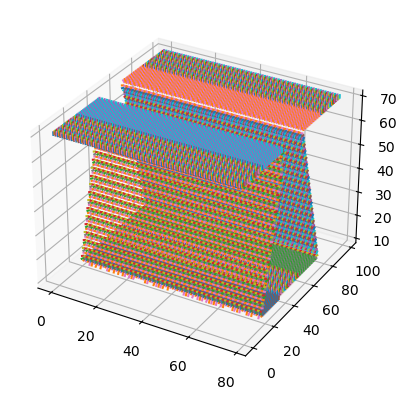

In [67]:
ax = plt.figure().add_subplot(projection='3d')
for i in range(20000):

    planes[i,0:3] = normal_all[i] #Keep the coordinates of the normal vectors
    planes[i,3:6] = pointsNP[i] #Keep the coordinates of the centroid
    
    # ax.scatter(pointsNP[i,0],pointsNP[i,1],pointsNP[i,2], facecolors='none',edgecolors = 'c')
    ax.plot([pointsNP[i,0],pointsNP[i,0]+normal_all[i,0]],[pointsNP[i,1],pointsNP[i,1]+normal_all[i,1]],[pointsNP[i,2],pointsNP[i,2]+normal_all[i,2]])
    print(i)
# plt.show()

In [ ]:
def tangentplane_3D_real(closest_pt,ellipsoid_data,k):
    
    """
    
    This function calculates the centre point c of a cloud of points knni and returns
    the normal of the tangent plane best fitting the coud of points
    
        Input: 
            knni: Array of indexes representing the nearest point (index) to the first point of the row knni[i]
            ellipsoid: x,y,z coordinates of points defining the ellipsoid. We will use it to give coordinates to each index in knni
            k: Number of closest points we want to calculate for a given point
            
    """
    
    "Extraction of the coordinates of each point from their indexes and the matrix ellipsoid"
    
    knn_pt_id = closest_pt[0:k] # Retain only the indexes of the k-closest points
    nb_points = np.size(knn_pt_id)
    knn_pt_coord = np.zeros((nb_points,3)) 
    
    for i in range(nb_points):
        
        point_i = knn_pt_id[i]
        
        knn_pt_coord[i,:] = ellipsoid_data[point_i,:]
    
    "Principal component analysis (PCA)"
    
    "Centorid calculation"
        
    xmn = np.mean(knn_pt_coord[:,0])
    ymn = np.mean(knn_pt_coord[:,1])
    zmn = np.mean(knn_pt_coord[:,2])
    
    c=np.zeros((np.size(knn_pt_coord,0),3))
    
    c[:,0] = knn_pt_coord[:,0]-xmn
    c[:,1] = knn_pt_coord[:,1]-ymn
    c[:,2] = knn_pt_coord[:,2]-zmn
    
    "Covariance matrix"
    
    cov=np.zeros((3,3))    
    
    cov[0,0] = np.dot(c[:,0],c[:,0])
    cov[0,1] = np.dot(c[:,0],c[:,1])
    cov[0,2] = np.dot(c[:,0],c[:,2])
    
    cov[1,0] = cov[0,1]
    cov[1,1] = np.dot(c[:,1],c[:,1])
    cov[1,2] = np.dot(c[:,1],c[:,2])
    
    cov[2,0] = cov[0,2]
    cov[2,1] = cov[1,2]
    cov[2,2] = np.dot(c[:,2],c[:,2])
   
    "Single value decomposition (SVD)"
    
    u,s,vh = np.linalg.svd(cov) # U contains the orthonormal eigenvectors and S contains the eigenvectors

    "Selection of minimum eigenvalue"
    
    minevindex = np.argmin(s)
    
    "Selection of orthogonal vector corresponing to this eigenvalue --> vector normal to the plane defined by the kpoints"
    
    normal_vect = u[:,minevindex]

    return normal_vect, xmn, ymn,zmn,knn_pt_coord

In [17]:
def tangentplane_3D_real(closest_pt,ellipsoid_data,k):
    
    """
    
    This function calculates the centre point c of a cloud of points knni and returns
    the normal of the tangent plane best fitting the coud of points
    
        Input: 
            knni: Array of indexes representing the nearest point (index) to the first point of the row knni[i]
            ellipsoid: x,y,z coordinates of points defining the ellipsoid. We will use it to give coordinates to each index in knni
            k: Number of closest points we want to calculate for a given point
            
    """
    
    "Extraction of the coordinates of each point from their indexes and the matrix ellipsoid"
    
    knn_pt_id = closest_pt[0:k] # Retain only the indexes of the k-closest points
    nb_points = np.size(knn_pt_id)
    knn_pt_coord = np.zeros((nb_points,3)) 
    
    for i in range(nb_points):
        
        point_i = knn_pt_id[i]
        
        knn_pt_coord[i,:] = ellipsoid_data[point_i,:]
    
    "Principal component analysis (PCA)"
    
    "Centorid calculation"
        
    xmn = np.mean(knn_pt_coord[:,0])
    ymn = np.mean(knn_pt_coord[:,1])
    zmn = np.mean(knn_pt_coord[:,2])
    
    c=np.zeros((np.size(knn_pt_coord,0),3))
    
    c[:,0] = knn_pt_coord[:,0]-xmn
    c[:,1] = knn_pt_coord[:,1]-ymn
    c[:,2] = knn_pt_coord[:,2]-zmn
    
    "Covariance matrix"
    
    cov=np.zeros((3,3))    
    
    cov[0,0] = np.dot(c[:,0],c[:,0])
    cov[0,1] = np.dot(c[:,0],c[:,1])
    cov[0,2] = np.dot(c[:,0],c[:,2])
    
    cov[1,0] = cov[0,1]
    cov[1,1] = np.dot(c[:,1],c[:,1])
    cov[1,2] = np.dot(c[:,1],c[:,2])
    
    cov[2,0] = cov[0,2]
    cov[2,1] = cov[1,2]
    cov[2,2] = np.dot(c[:,2],c[:,2])
   
    "Single value decomposition (SVD)"
    
    u,s,vh = np.linalg.svd(cov) # U contains the orthonormal eigenvectors and S contains the eigenvectors

    "Selection of minimum eigenvalue"
    
    minevindex = np.argmin(s)
    
    "Selection of orthogonal vector corresponing to this eigenvalue --> vector normal to the plane defined by the kpoints"
    
    normal_vect = u[:,minevindex]

    return normal_vect, xmn, ymn,zmn,knn_pt_coord

0
1
2
3
4
5
6
7
8
9


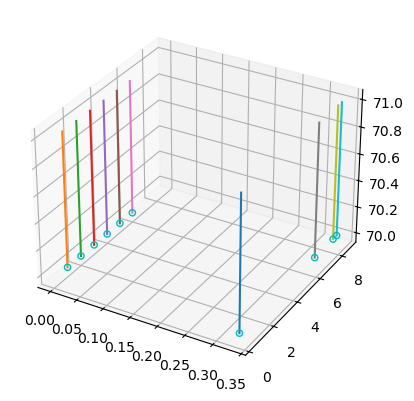

In [26]:
ax = plt.figure().add_subplot(projection='3d')
for i in range(10):

    normal_vect, xmn,ymn,zmn, knn_pt_coord = tangentplane_3D_real(closest[i,:],points,3) #Obtention of the normal and centroid (and other parametres) for each point in the ellipsoid

    planes[i,0:3] = normal_vect #Keep the coordinates of the normal vectors
    planes[i,3:6] = np.array([xmn, ymn, zmn]) #Keep the coordinates of the centroid
    
    ax.scatter(xmn,ymn,zmn, facecolors='none',edgecolors = 'c')
    ax.plot([xmn,xmn+normal_vect[0]],[ymn,ymn+normal_vect[1]],[zmn,zmn+normal_vect[2]])
    print(i)
# plt.show()
    # plt.hold(True)
    
# planes_consist = normalconsistency_3D_real(planes)

In [ ]:
def scanZ(film):
    zmap = np.zeros((100, 100))
    zshape = film.shape[2]
    print(zshape)
    for i in range(zshape):
        for j in range(100):
            for k in range(100):
                if film[j, k, i] == 0 and film[j, k, i-1] != 0:
                    zmap[j,k] = i
    return zmap

In [23]:
def scanZmin(film):
    zmap = np.zeros((100, 100))
    zshape = film.shape[2]
    print(zshape)
    for i in range(zshape):
        for j in range(100):
            for k in range(100):
                if film[j, k, zshape-1-i] == 0 and film[j, k, zshape-i] != 0:
                    zmap[j,k] = i
    return zmap

In [24]:
def mesh_normal(p1, p2, p3):
    origin_Z = (p1[2] + p2[2] + p3[2])/3
    origin_X = (p1[0] + p2[0] + p3[0])/3
    origin_Y = (p1[1] + p2[1] + p3[1])/3
    a = p1 - p2
    b = p2 - p3

    c = np.cross(a, b)
    c_normal = np.linalg.norm(c)
    n = c/c_normal
    return n, np.array([origin_X, origin_Y, origin_Z])

In [26]:
test = scanZ(film)
print(test)

100
13800
13800
13800
  (0, 0)	70
  (0, 1)	70
  (0, 2)	70
  (0, 3)	70
  (0, 4)	70
  (0, 5)	70
  (1, 0)	70
  (1, 1)	70
  (1, 2)	70
  (1, 3)	70
  (1, 4)	70
  (1, 5)	70
  (2, 0)	70
  (2, 1)	70
  (2, 2)	70
  (2, 3)	70
  (2, 4)	70
  (2, 5)	70
  (3, 0)	70
  (3, 1)	70
  (3, 2)	70
  (3, 3)	70
  (3, 4)	70
  (3, 5)	70
  (4, 0)	70
  :	:
  (97, 101)	0
  (98, 96)	70
  (98, 97)	70
  (98, 98)	70
  (98, 99)	70
  (98, 100)	0
  (98, 101)	0
  (99, 96)	70
  (99, 97)	70
  (99, 98)	70
  (99, 99)	70
  (99, 100)	0
  (99, 101)	0
  (100, 96)	0
  (100, 97)	0
  (100, 98)	0
  (100, 99)	0
  (100, 100)	0
  (100, 101)	0
  (101, 96)	0
  (101, 97)	0
  (101, 98)	0
  (101, 99)	0
  (101, 100)	0
  (101, 101)	0


In [28]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 0, 2, 0, 1, 2])
data = np.array([1, 2, 3 ,4, 5, 6])
bsr_matrix((data, (row, col)), shape=(6, 6)).toarray()

array([[3, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [4, 5, 6, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)

In [26]:
test[20:30, :]

array([[70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70.],
       [70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70

In [27]:
test = scanZmin(film)
print(test)

100


IndexError: index 100 is out of bounds for axis 2 with size 100

In [68]:
def get_normal(film):
    normal_film = np.zeros((film.shape[0], film.shape[1], 3))
    origin_film = np.zeros((film.shape[0], film.shape[1], 3))
    for i in range(film.shape[0]-1):
        for j in range(film.shape[1]-1):
            if i%2 == 0:
                n1, o1 = mesh_normal(np.array([i,j,film[i, j]]), np.array([i,j+1,film[i, j+1]]), np.array([i+1,j+1,film[i+1, j+1]]))
                # print(n1)
                normal_film[i,j] = -n1
                origin_film[i,j] = o1
            else:
                n2, o2 = mesh_normal(np.array([i,j,film[i, j]]), np.array([i+1,j,film[i+1, j]]), np.array([i+1,j+1,film[i+1, j+1]]))
                # print(n2)
                normal_film[i,j] = n2
                origin_film[i,j] = o2
    return normal_film, origin_film 

In [70]:
normal_test, origin_test = get_normal(test)

In [78]:
test = np.random.randint(90,100,size=(100, 100))
print(test)
normal_test, origin_test = get_normal(test)

[[99 98 93 ... 93 98 94]
 [92 93 91 ... 91 91 98]
 [90 95 98 ... 92 94 95]
 ...
 [99 92 99 ... 90 91 92]
 [91 90 97 ... 98 91 91]
 [96 97 95 ... 96 90 96]]


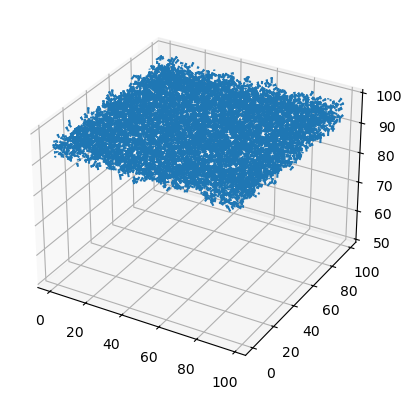

In [83]:
ax = plt.figure().add_subplot(projection='3d')

ax.quiver(origin_test[:,:,0],origin_test[:,:,1],origin_test[:,:,2], normal_test[:,:,0],normal_test[:,:,1],normal_test[:,:,2], length=2, normalize=True)
ax.set_zlim(50,100)
plt.show()

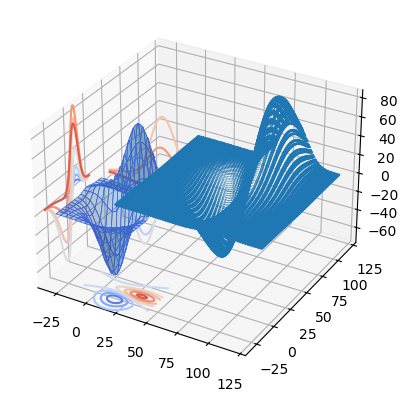

In [92]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
normal_test, origin_test = get_normal(Z)
ax.quiver(origin_test[:,:,0],origin_test[:,:,1],origin_test[:,:,2], normal_test[:,:,0],normal_test[:,:,1],normal_test[:,:,2], length=2, normalize=True)
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, Z, zdir='z', offset=-100, cmap='coolwarm')
ax.contour(X, Y, Z, zdir='x', offset=-40, cmap='coolwarm')
ax.contour(X, Y, Z, zdir='y', offset=40, cmap='coolwarm')

# ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
#        xlabel='X', ylabel='Y', zlabel='Z')

# plt.show()

In [91]:
Z.shape

(120, 120)

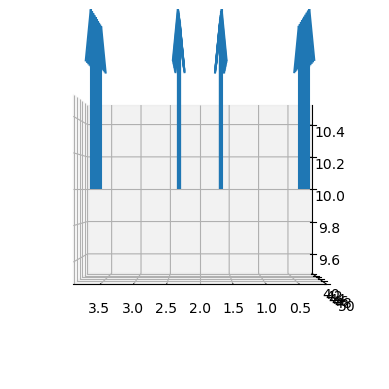

In [67]:
ax = plt.figure().add_subplot(projection='3d')

ax.quiver(origin_test[:4,40:50,0],origin_test[:4,40:50,1],origin_test[:4,40:50,2], normal_test[:4,40:50,0],normal_test[:4,40:50,1],normal_test[:4,40:50,2], normalize=True)
ax.view_init(elev=0, azim=90, roll=0)
plt.show()


In [85]:
X.shape

(120, 120)

In [29]:
test[20:30, 20:30]

array([[70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.],
       [70., 67., 64., 61., 58., 55., 52., 49., 46., 43.]])

In [4]:
def mesh_normal(p1, p2, p3):
    origin_Z = (p1[2] + p2[2] + p3[2])/3
    origin_X = (p1[0] + p2[0] + p3[0])/3
    origin_Y = (p1[1] + p2[1] + p3[1])/3
    a = p1 - p2
    b = p2 - p3
    c = np.cross(a, b)
    c_normal = np.linalg.norm(c)
    n = c/c_normal
    return n, np.array([origin_X, origin_Y, origin_Z])